In [1]:
import numpy as np
from scipy import signal
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import pandas as pd

from filt_plot_funcs import *

fs = 200


In [2]:
def printBiquadInArmFormat(sos):
    # Remove `a0` coefficients and flip sign of `a1` and `a2`
    sos = np.float32(sos)
    sos = np.delete(sos, 3, 1)
    sos[:, 3:] *= -1
    
    # Print sections
    print("{", end='\n')
    for section_num, section in enumerate(sos):
        print((" " * 4) + f"// Section {section_num+1}\n", end='')
        for idx, val in enumerate(section):
            if idx == 0 or idx == 3: print(" " * 4, end='')
            print(f"{val}f, ", end='')
            if idx == 2: print("\n", end='')
            
        print("\n", end='')
    
    print("};", end='')
    
    return


### Bandpass Filter

#### High Pass Filter

In [3]:
sos_high = signal.iirfilter(N=4, Wn=12, btype='highpass', output='sos', fs=fs)
printBiquadInArmFormat(sos_high)

{
    // Section 1
    0.6089446544647217f, -1.2178893089294434f, 0.6089446544647217f, 
    1.3876197338104248f, -0.492422878742218f, 
    // Section 2
    1.0f, -2.0f, 1.0f, 
    1.6299355030059814f, -0.7530401945114136f, 
};

In [4]:
z_high, p_high, k_high = signal.sos2zpk(sos_high)
print(f"abs(p) = {np.abs(p_high)}")


abs(p) = [0.7017285  0.7017285  0.86777887 0.86777887]


/Users/bryanmcelvy/Documents/project_dir/ecg_hrm/tools/filter_design/filt_plot_funcs.py:128: UserWarning: The filter's denominator is extremely small at frequencies [0.000],             around which a singularity may be present
  freq, grd = signal.group_delay([b, a], N, fs=fs)


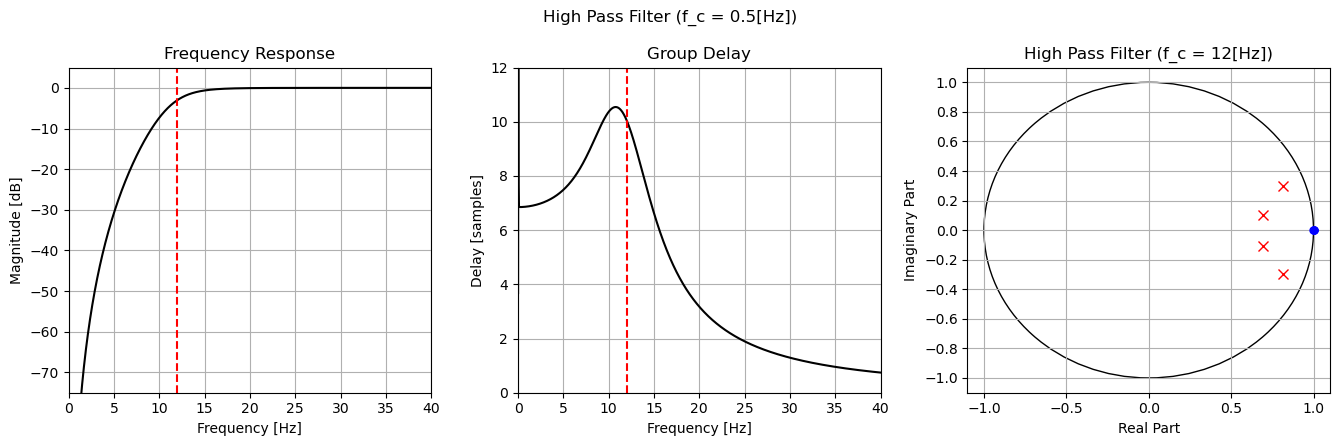

In [5]:
fig_high, axs_high = plt.subplots(1, 3, tight_layout=True, figsize=[13.5, 4.5])

b_high, a_high = signal.sos2tf(sos_high)
plot_freq_domain(b_high, a_high, fs=fs, in_dB=True, ax1=axs_high[0], ax2=axs_high[1], filt_name="High Pass Filter (f_c = 0.5[Hz])")
plot_pole_zero(b_high, a_high, ax=axs_high[2], filt_name="High Pass Filter (f_c = 12[Hz])")

for n in range(2):
    plt.sca(axs_high[n])
    plt.xlim([0, 40])
    plt.xticks(np.arange(0, 41, 5))
    plt.ylim([-75, 5] if n == 0 else [0, 12])
    
    plt.axvline(12, linestyle='dashed', color='r')


#### Low Pass Filter

In [6]:
sos_low = signal.iirfilter(N=4, Wn=20, btype='lowpass', output='sos', fs=fs)
printBiquadInArmFormat(sos_low)

{
    // Section 1
    0.004824343137443066f, 0.009648686274886131f, 0.004824343137443066f, 
    1.0485996007919312f, -0.2961403429508209f, 
    // Section 2
    1.0f, 2.0f, 1.0f, 
    1.3209134340286255f, -0.6327387690544128f, 
};

In [7]:
z_low, p_low, k_low = signal.sos2zpk(sos_low)
print(f"abs(p) = {np.abs(p_low)}")


abs(p) = [0.5441878 0.5441878 0.7954488 0.7954488]


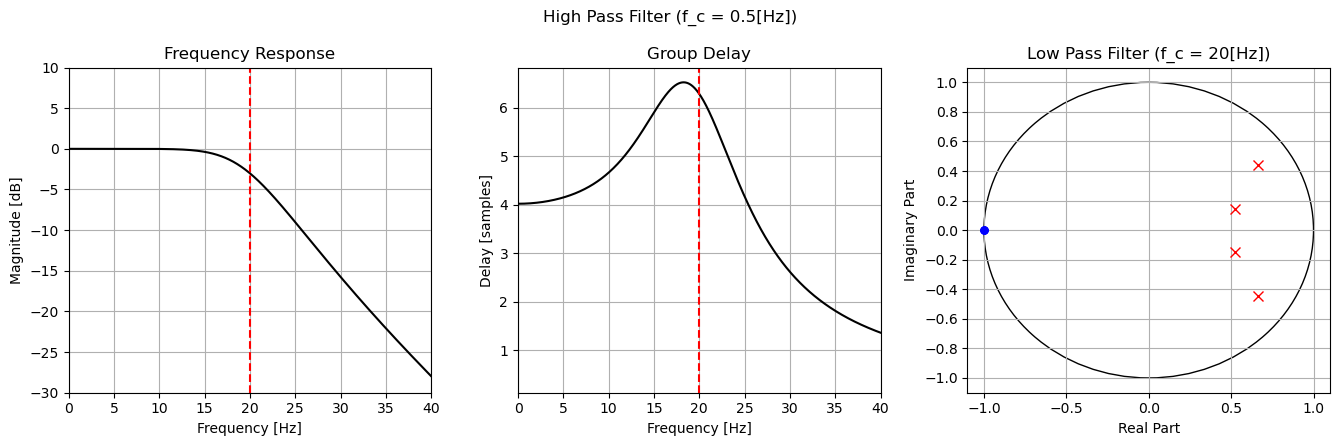

In [8]:
fig_low, axs_low = plt.subplots(1, 3, tight_layout=True, figsize=[13.5, 4.5])

b_low, a_low = signal.sos2tf(sos_low)
plot_freq_domain(b_low, a_low, fs=fs, in_dB=True, ax1=axs_low[0], ax2=axs_low[1], filt_name="High Pass Filter (f_c = 0.5[Hz])")
plot_pole_zero(b_low, a_low, ax=axs_low[2], filt_name="Low Pass Filter (f_c = 20[Hz])")

for i in range(2):
    plt.sca(axs_low[i])
    plt.xlim([0, 40])
    plt.xticks(np.arange(0, 41, 5))
    plt.axvline(20, linestyle='dashed', color='r')
    if i == 0: plt.ylim([-30, 10])


#### Overall Bandpass Filter

In [9]:
z_bpf = np.concatenate([z_high, z_low])
p_bpf = np.concatenate([p_high, p_low])
k_bpf = k_high * k_low

print(np.sort( np.abs(p_bpf) ))

[0.5441878  0.5441878  0.7017285  0.7017285  0.7954488  0.7954488
 0.86777887 0.86777887]


In [10]:
sos_bpf = signal.zpk2sos(z_bpf, p_bpf, k_bpf)

printBiquadInArmFormat(sos_bpf)


{
    // Section 1
    0.002937758108600974f, 0.005875516217201948f, 0.002937758108600974f, 
    1.0485996007919312f, -0.2961403429508209f, 
    // Section 2
    1.0f, 2.0f, 1.0f, 
    1.3876197338104248f, -0.492422878742218f, 
    // Section 3
    1.0f, -2.0f, 1.0f, 
    1.3209134340286255f, -0.6327387690544128f, 
    // Section 4
    1.0f, -2.0f, 1.0f, 
    1.6299355030059814f, -0.7530401945114136f, 
};

/Users/bryanmcelvy/Documents/project_dir/ecg_hrm/tools/filter_design/filt_plot_funcs.py:128: UserWarning: The filter's denominator is extremely small at frequencies [0.000, 0.001, 0.002, 0.002],             around which a singularity may be present
  freq, grd = signal.group_delay([b, a], N, fs=fs)


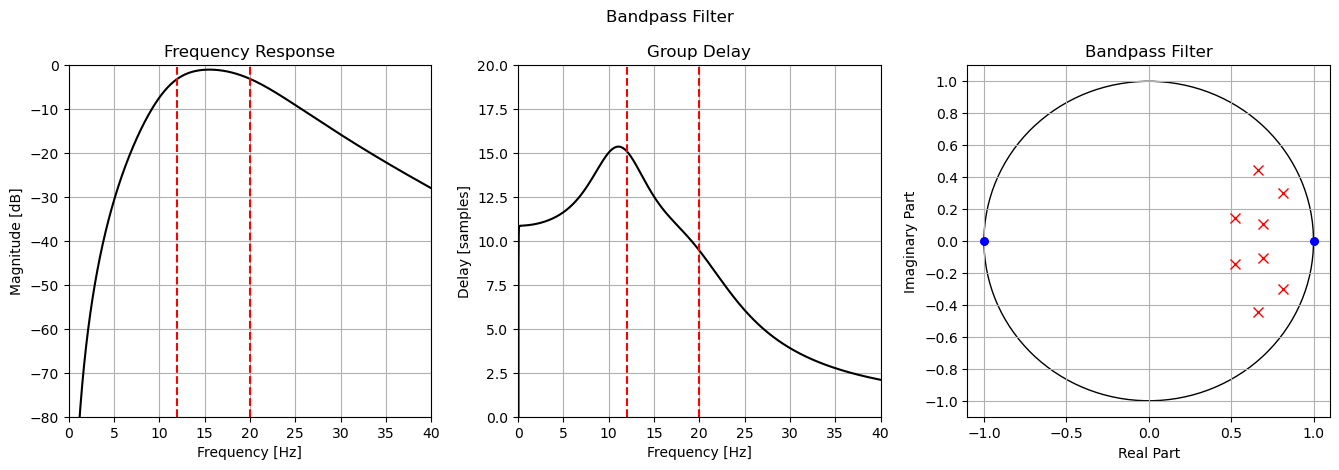

In [11]:
fig_bpf, axs_bpf = plt.subplots(1, 3, tight_layout=True, figsize=[13.5, 4.75])

b_bpf, a_bpf = signal.sos2tf(sos_bpf)
plot_freq_domain(b_bpf, a_bpf, fs=fs, in_dB=True, ax1=axs_bpf[0], ax2=axs_bpf[1], filt_name="Bandpass Filter")
plot_pole_zero(b_bpf, a_bpf, ax=axs_bpf[2], filt_name="Bandpass Filter")

for n in range(2):
    plt.sca(axs_bpf[n])
    
    plt.xlim([0, 40])
    plt.xticks(np.arange(0, 41, 5))
    plt.ylim([-80, 0] if n == 0 else [0, 20])
    
    plt.axvline(12, linestyle='dashed', color='r')
    plt.axvline(20, linestyle='dashed', color='r')


### Derivative Filter

In [12]:
b_der = np.array( [1, 2, 0, -2, -1] ) / 8
a_der = 1

print("{", end='')
for n in b_der:
    print(f"{n}f, ", end='')
    
print("};", end='')


{0.125f, 0.25f, 0.0f, -0.25f, -0.125f, };

In [13]:
z_der, p_der, k_der = signal.tf2zpk(b_der, a_der)


/Users/bryanmcelvy/opt/anaconda3/envs/ecg_hrm_py/lib/python3.9/site-packages/scipy/signal/_filter_design.py:693: RuntimeWarning: divide by zero encountered in divide
  gd = np.real(num / den) - a.size + 1
/Users/bryanmcelvy/opt/anaconda3/envs/ecg_hrm_py/lib/python3.9/site-packages/scipy/signal/_filter_design.py:693: RuntimeWarning: invalid value encountered in divide
  gd = np.real(num / den) - a.size + 1
/Users/bryanmcelvy/Documents/project_dir/ecg_hrm/tools/filter_design/filt_plot_funcs.py:128: UserWarning: The group delay is singular at frequencies [0.000], setting to 0
  freq, grd = signal.group_delay([b, a], N, fs=fs)


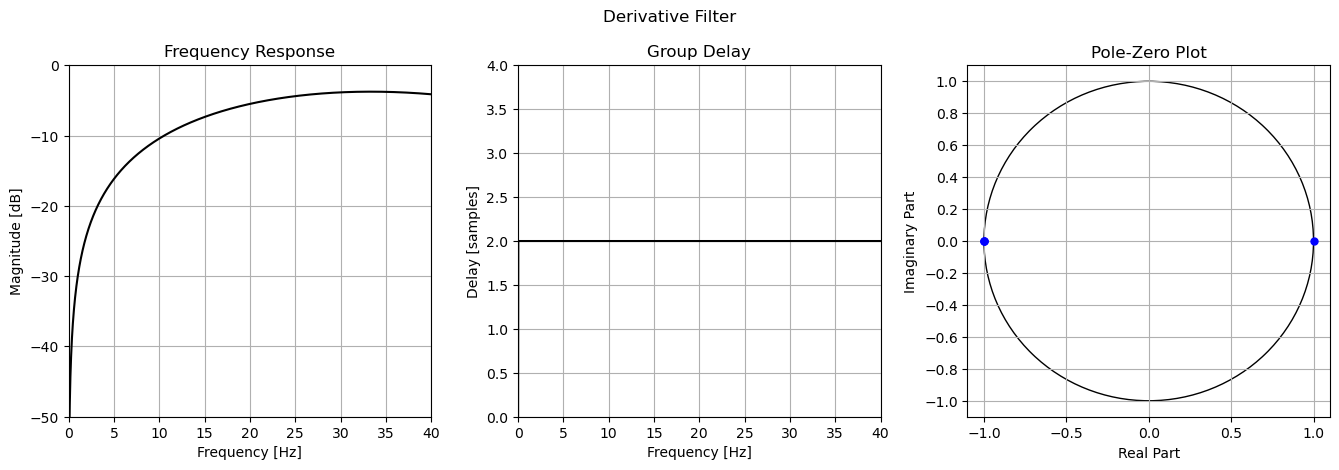

In [14]:
fig_der, axs_der = plt.subplots(1, 3, tight_layout=True, figsize=[13.5, 4.75])

plot_freq_domain(b_der, a_der, fs=fs, in_dB=True, ax1=axs_der[0], ax2=axs_der[1], filt_name="Derivative Filter")
plot_pole_zero(b_der, a_der, ax=axs_der[2])

for n in range(2):
    plt.sca(axs_der[n])
    
    plt.xlim([0, 40])
    plt.xticks(np.arange(0, 41, 5))
    
    plt.ylim([-50, 0] if n == 0 else [0, 4])


### Moving Average Filter

In [15]:
M = 30
b_ma = np.ones(M, dtype=np.float32) / M
a_ma = 1

print("{", end='')
for n in b_ma:
    print(f"{n}f, ", end='')
    
print("};", end='')

{0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, 0.03333333507180214f, };

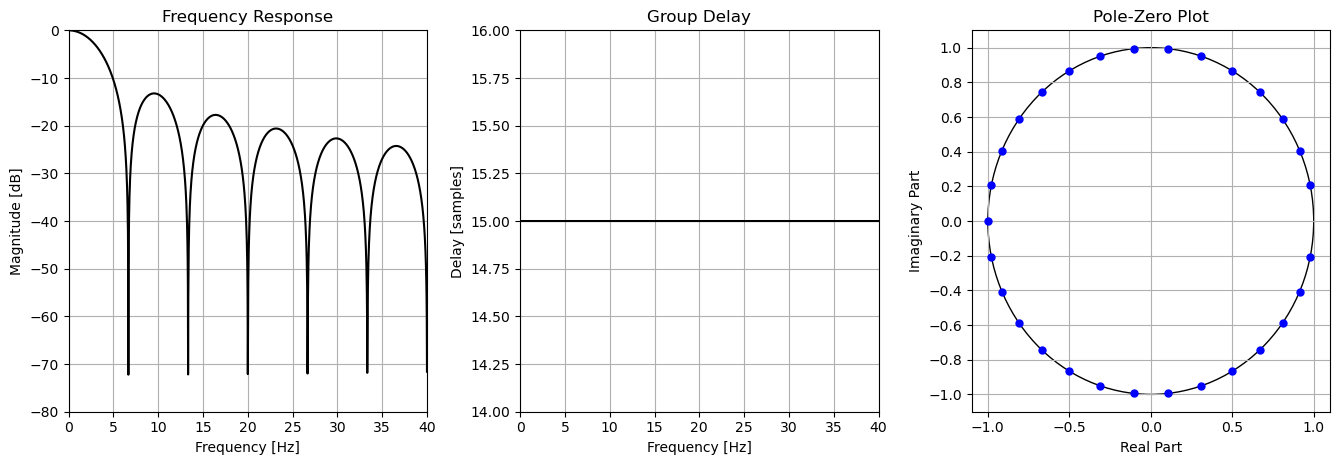

In [16]:
fig_der, axs_der = plt.subplots(1, 3, tight_layout=True, figsize=[13.5, 4.75])

plot_freq_domain(b_ma, a_ma, fs=fs, in_dB=True, ax1=axs_der[0], ax2=axs_der[1])
plot_pole_zero(b_ma, a_ma, ax=axs_der[2])

for n in range(2):
    plt.sca(axs_der[n])
    
    plt.xlim([0, 40])
    plt.xticks(np.arange(0, 41, 5))
    
    plt.ylim([-80, 0] if n == 0 else [14, 16])
